In [2]:
import pandas as pd
import lifelines
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test,multivariate_logrank_test

In [3]:
import os
dir_path = './'

In [185]:
import numpy as np
df = pd.read_excel(os.path.join(dir_path, "survival_data_immunotyping_0116.xlsx"))
print(df.head())
df_p=pd.read_csv(os.path.join(dir_path,'result_Tumor_tils_density_test.csv'))#('ki_in"vasion_celltype_relation (1).csv') #('result_Tumor_tils_density_test.csv')

df_p.rename(columns={'file_name':'id'}, inplace=True)
for i, item in df_p.iterrows():
    df_p.loc[i,'id']=int(df_p.loc[i, 'id'].split('_')[2])
df_p.head()



         id  alive_0_yes_1_no  OS_in_months Hospital  OS_in_days
0  32392504                 0            99        s        2970
1  34162273                 0             8        s         240
2  35091499                 1            10        s         300
3  42605973                 0            92        s        2760
4  42628813                 0           100        s        3000


,id,immune_infl,immune_excl,immune_des
0,35537724,0.013441,0.000000,0.986559
1,50414154,0.012821,0.000000,0.987179
2,50414154,0.017544,0.003509,0.978947
3,37342030,0.012658,0.000000,0.987342
4,43870422,0.019608,0.009804,0.970588


In [212]:
df_m=pd.merge(df_p,df[['id', 'OS_in_days','alive_0_yes_1_no']], on='id',how='inner')
df_m.to_csv('test.csv')
print(df_m.columns)
print(len(df_m))
for column in df_m.columns:
    if 'Unnamed' in column:
        df_m=df_m.drop(columns = column)
null_index = df_m.index[df_m['OS_in_days'].isnull()==True]
df_m = df_m.drop(df_m.index[null_index])
null_index = df_m.index[df_m['alive_0_yes_1_no'].isnull()==True]
df_m = df_m.drop(df_m.index[null_index])

df_m.head()


Index(['id', 'immune_infl', 'immune_excl', 'immune_des', 'OS_in_days',
       'alive_0_yes_1_no'],
      dtype='object')
1260


,id,immune_infl,immune_excl,immune_des,OS_in_days,alive_0_yes_1_no
0,35537724,0.013441,0.0,0.986559,3420,1
1,50414154,0.012821,0.0,0.987179,540,0
2,50414154,0.012821,0.0,0.987179,540,0
3,50414154,0.012821,0.0,0.987179,540,0
4,50414154,0.012821,0.0,0.987179,540,0


In [213]:
df = df_m.copy()
for j in ['immune_infl', 'immune_excl', 'immune_des']:
    per=df_m[j].quantile([0.25,0.5,0.75])
    for i in range(len(df_m)):
        if float(df_m[j][i])<=float(per[0.25]):
            df[j][i]='low'
        elif float(per[0.25])<float(df_m[j][i])<=float(per[0.75]):
            df[j][i]='medium'
        elif float(df_m[j][i])>float(per[0.75]):
            df[j][i]='high'


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [207]:
df.head()

,id,immune_infl,immune_excl,immune_des,OS_in_days,alive_0_yes_1_no
0,35537724,medium,low,medium,3420,1
1,50414154,medium,low,medium,540,0
2,50414154,medium,low,medium,540,0
3,50414154,medium,low,medium,540,0
4,50414154,medium,low,medium,540,0


In [208]:
# SURVIVAL ANALYSIS PLOTTING FUNCTIONS: copied from github/lifelines and edited for customization
def is_latex_enabled(): 
    '''
    Returns True if LaTeX is enabled in matplotlib's rcParams,
    False otherwise
    '''
    import matplotlib as mpl

    return mpl.rcParams['text.usetex']


def remove_spines(ax, sides):
    '''
    Remove spines of axis.
    Parameters:
      ax: axes to operate on
      sides: list of sides: top, left, bottom, right
    Examples:
    removespines(ax, ['top'])
    removespines(ax, ['top', 'bottom', 'right', 'left'])
    '''
    for side in sides:
        ax.spines[side].set_visible(False)
    return ax


def move_spines(ax, sides, dists):
    '''
    Move the entire spine relative to the figure.
    Parameters:
      ax: axes to operate on
      sides: list of sides to move. Sides: top, left, bottom, right
      dists: list of float distances to move. Should match sides in length.
    Example:
    move_spines(ax, sides=['left', 'bottom'], dists=[-0.02, 0.1])
    '''
    for side, dist in zip(sides, dists):
        ax.spines[side].set_position(('axes', dist))
    return ax


def remove_ticks(ax, x=False, y=False):
    '''
    Remove ticks from axis.
    Parameters:
      ax: axes to work on
      x: if True, remove xticks. Default False.
      y: if True, remove yticks. Default False.
    Examples:
    removeticks(ax, x=True)
    removeticks(ax, x=True, y=True)
    '''
    if x:
        ax.xaxis.set_ticks_position('none')
    if y:
        ax.yaxis.set_ticks_position('none')
    return ax

def add_at_risk_counts_CUSTOM(*fitters, **kwargs): 
    '''
    Add counts showing how many individuals were at risk at each time point in
    survival/hazard plots.
    Arguments:
      One or several fitters, for example KaplanMeierFitter,
      NelsonAalenFitter, etc...
    Keyword arguments (all optional):
      ax: The axes to add the labels to. Default is the current axes.
      fig: The figure of the axes. Default is the current figure.
      labels: The labels to use for the fitters. Default is whatever was
              specified in the fitters' fit-function. Giving 'None' will
              hide fitter labels.
    Returns:
      ax: The axes which was used.
    Examples:
        # First train some fitters and plot them
        fig = plt.figure()
        ax = plt.subplot(111)
        f1 = KaplanMeierFitter()
        f1.fit(data)
        f1.plot(ax=ax)
        f2 = KaplanMeierFitter()
        f2.fit(data)
        f2.plot(ax=ax)
        # There are equivalent
        add_at_risk_counts(f1, f2)
        add_at_risk_counts(f1, f2, ax=ax, fig=fig)
        # This overrides the labels
        add_at_risk_counts(f1, f2, labels=['fitter one', 'fitter two'])
        # This hides the labels
        add_at_risk_counts(f1, f2, labels=None)
    '''

    # Axes and Figure can't be None
    ax = kwargs.get('ax', None)
    if ax is None:
        ax = plt.gca()

    fig = kwargs.get('fig', None)
    if fig is None:
        fig = plt.gcf()

    fontsize = kwargs.get('fontsize', None)
    if fontsize is None:
        fontsize = 15
        
    if 'labels' not in kwargs:
        labels = [f._label for f in fitters]
        #print(labels)
    else:
        # Allow None, in which case no labels should be used
        labels = kwargs['labels']
        if labels is None:
            labels = [None] * len(fitters)
    # Create another axes where we can put size ticks
    ax2 = plt.twiny(ax=ax)
    # Move the ticks below existing axes
    # Appropriate length scaled for 6 inches. Adjust for figure size.
    ax2_ypos = -0.20 * 6.0 / fig.get_figheight()
    move_spines(ax2, ['bottom'], [ax2_ypos])
    # Hide all fluff
    remove_spines(ax2, ['top', 'right', 'bottom', 'left'])
    # Set ticks and labels on bottom
    ax2.xaxis.tick_bottom()
    # Match tick numbers and locations
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xlim(ax.get_xlim())
    
    # Remove ticks, need to do this AFTER moving the ticks
    remove_ticks(ax2, x=True, y=True)
    # Add population size at times
    ticklabels = []
    for tick in ax2.get_xticks():
        lbl = ""
        for f, l in zip(fitters, labels):
            # First tick is prepended with the label
            #print(f,l)
            if tick == ax2.get_xticks()[0] and l is not None:
                if is_latex_enabled():
                    s = "\n{}\\quad".format(l) + "{}"
                else:
                    s = "\n{}   ".format(l) + "{}"
            else:
                s = "\n{}"
            lbl += s.format(f[f >= tick].shape[0])
        ticklabels.append(lbl.strip())
    # Align labels to the right so numbers can be compared easily
    #print(ticklabels)
    ax2.set_xticklabels(ticklabels, ha='right', fontsize=10)

    # Add a descriptive headline.
    ax2.xaxis.set_label_coords(0, ax2_ypos)
    ax2.set_xlabel('At risk', fontsize=10)

    plt.tight_layout()
    return ax2

In [214]:
def plot_km(col,df,T,C):
    #plt.figure()
    kmf = KaplanMeierFitter()
    ax = plt.subplot(111)
     # Create another axes where we can put size ticks
    fitters=[]
    labels=[]
    df_d=pd.DataFrame()
    df_E=pd.DataFrame()
    G=[]
    
    j=0
    
    for r in df[col].unique():
        
        ix = df[col]==r
        c=kmf.fit(durations=T[ix], event_observed=C[ix],label=r)
        fitters.append(c.durations)
        df_d=pd.concat([df_d.reset_index(drop=True),T[ix].reset_index(drop=True)],axis=0)
        df_E=pd.concat([df_E.reset_index(drop=True),C[ix].reset_index(drop=True)],axis=0)
        G.append(np.zeros(len(T[ix]))+j)
        
        labels.append(r)
        kmf.plot(ax=ax,ci_show=False, show_censors=True)
        plt.ylim([0,1.2])
        plt.ylabel('Survival probability')
        plt.xlabel('Time in years')
        #plt.legend(bbox_to_anchor=(0, 1.5, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
        plt.legend(loc="upper left", mode = "expand", ncol = 3)
        ax.grid(False)
        j+=1
    d_list=df_d.values.tolist()
    e_list=df_E.values.tolist()
    d_list=np.hstack(d_list)
    e_list=np.hstack(e_list)
    G=np.hstack(G)
    return fitters,labels,ax,d_list,e_list,G

In [181]:
df.head()

,id,immune_infl,immune_excl,immune_des,OS_in_days,alive_0_yes_1_no
0,35537724,medium,low,medium,3420,1
1,50414154,medium,low,medium,540,0
2,50414154,medium,high,medium,540,0
3,37342030,medium,low,medium,2610,0
4,43870422,medium,high,low,2580,0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


3
['medium', 'low', 'high']
0.007102684398528781


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           9.89 0.01      7.14

3
['low', 'medium', 'high']
0.00010599899323538075


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          18.30 <0.005     13.20

2
['medium', 'low']
5.464990359609467e-07


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          25.09 <0.005     20.80

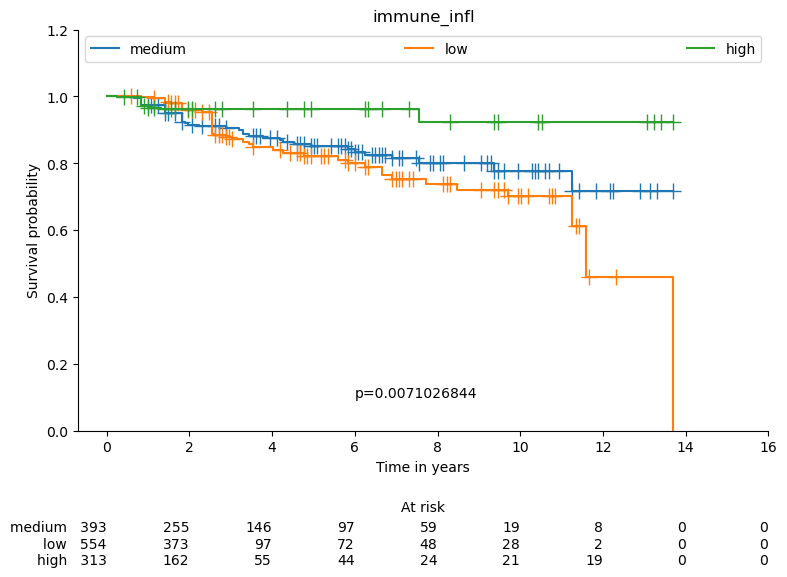

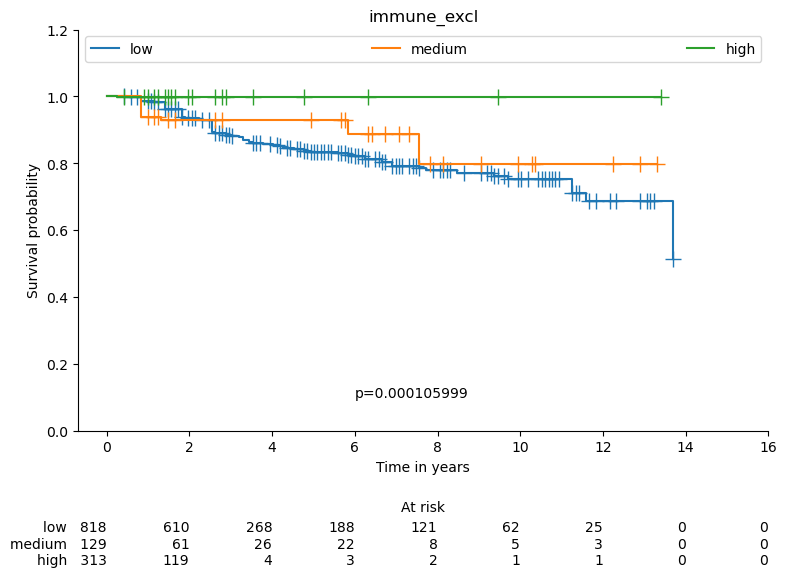

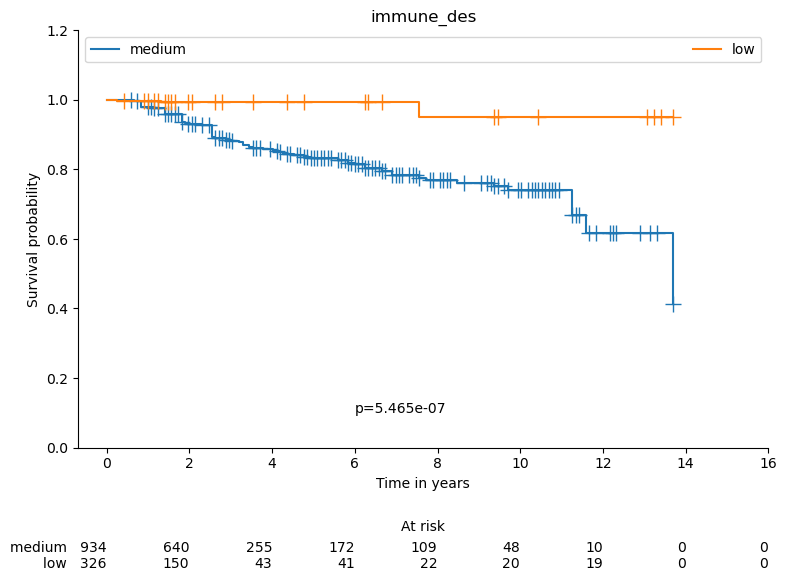

In [216]:
T=df['OS_in_days']
C=df['alive_0_yes_1_no'].astype(float)
T_hat = T
T_hat[T>5000]=5000 #inyeop
T_year=T_hat/365 #inyeop


columns = ['immune_infl', 'immune_excl', 'immune_des']

for r, j in enumerate(columns):
    plt.figure(figsize=(8, 6))
    fitters,labels,ax,d_list,e_list,G=plot_km(j,df,T_year,C) 
    print(len(fitters))
    print(labels)

    df_rank = pd.DataFrame({
        'durations': d_list,
        'events': e_list,
        'groups': G
    })
    result = multivariate_logrank_test(df_rank['durations'], df_rank['groups'], df_rank['events'])
    result.test_statistic
    print(result.p_value)
    result.print_summary()

    from lifelines.plotting import add_at_risk_counts
    import seaborn as sns
    sns.despine()
    newxticks = []
    for x in ax.get_xticks():
        if x >= 0:
            newxticks += [x]

    ax.set_xticks(newxticks)
    plt.title(j)
    plt.text(6,.1,'p={}'.format(round(result.p_value,10),'.3f'))
    if len(fitters)==2:
        ax2=add_at_risk_counts_CUSTOM(fitters[0],fitters[1],ax=ax,fontsize=10,labels=labels)
    elif len(fitters)==3:
        ax2=add_at_risk_counts_CUSTOM(fitters[0],fitters[1],fitters[2],ax=ax,fontsize=10,labels=labels)

plt.savefig('survival_d.png')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Int64Index([  29,   30,   31,   32,   33,   34,   35,   36,   37,   40,
            ...
            1174, 1175, 1176, 1177, 1178, 1179, 1217, 1228, 1250, 1254],
           dtype='int64', length=321)
Int64Index([  29,   30,   31,   32,   33,   34,   35,   36,  404,  460,
            ...
            1080, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1228],
           dtype='int64', length=170)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259],
           dtype='int64', length=1260)


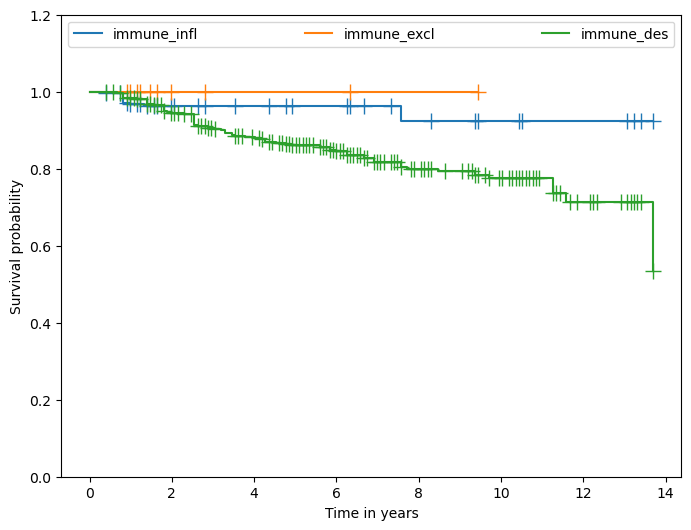

In [218]:
def plot_km1(df,T,C):
    #plt.figure()
    kmf = KaplanMeierFitter()
    ax = plt.subplot(111)
     # Create another axes where we can put size ticks

    
    for r in ['immune_infl', 'immune_excl', 'immune_des']:  
        
        ix = df[df[r]>0.05].index #inyeop threshold =0.05
        print(ix)
        c=kmf.fit(durations=T[ix], event_observed=C[ix],label=r)
        
        kmf.plot(ax=ax,ci_show=False, show_censors=True)
        plt.ylim([0,1.2])
        plt.ylabel('Survival probability')
        plt.xlabel('Time in years')
        #plt.legend(bbox_to_anchor=(0, 1.5, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
        plt.legend(loc="upper left", mode = "expand", ncol = 3)
        ax.grid(False)


T=df_m['OS_in_days']
C=df_m['alive_0_yes_1_no'].astype(float)
T[T>5000]=5000 #cut off for more than 5000 days
T_year=T/365 #from days to year
columns = ['immune_infl', 'immune_excl', 'immune_des']

plt.figure(figsize=(8, 6))
plot_km1(df_m,T_year,C) 
